# <nobr>Micro$\mathbb{S}$plit</nobr>: Semantic Unmixing of Fluorescent Microscopy Data

In this notebook, we tackle the problem of joint splitting and unsupervised denoising, which has a use case in the field of fluorescence microscopy. From a technical perspective, given a noisy image $x$, the goal is to predict two images $c_1$ and $c_2$ such that $x = c_1 + c_2 + n$, where $n$ is the noise in $x$. In other words, we have a superimposed image $x$ and we want to predict the denoised estimates of the constituent images $c_1$ and $c_2$. It is important to note that the network is trained with noisy data and the denoising is done in a unsupervised manner.

For this, we will use [denoiSplit](https://arxiv.org/pdf/2403.11854.pdf), a recently developed approach for this task. In this notebook we train denoiSplit and later evaluate it on one validation frame. The overall schema for denoiSplit is shown below:
<!-- Insert a figure -->
<!-- ![Schema](imgs/teaser.png) -->
<img src="imgs/teaser.png" alt="drawing" width="800"/>

<div class="alert alert-danger">
Set your python kernel to <code>05_image_restoration</code>
</div>

In [1]:
from functools import partial
from pathlib import Path

import torch
import matplotlib.pyplot as plt
from careamics.lightning import VAEModule
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader

from microsplit_reproducibility.configs.factory import (
    create_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.utils.callbacks import get_callbacks
from microsplit_reproducibility.utils.io import load_checkpoint_path
from microsplit_reproducibility.datasets import create_train_val_datasets
from microsplit_reproducibility.utils.utils import plot_input_patches
from microsplit_reproducibility.configs.parameters.custom_dataset_2D import (
    get_microsplit_parameters
)
from microsplit_reproducibility.configs.data.custom_dataset_2D import get_data_configs

from utils import get_train_val_data

%matplotlib inline

In [ ]:
assert torch.cuda.is_available()
torch.set_float32_matmul_precision('medium')

# **Exercise 1**: Training MicroSplit
Training is done in a supervised way. For every input patch, we have the two corresponding target patches using which we train our MicroSplit. 
Besides the primary input patch, we also feed LC inputs to MicroSplit. We introduced LC inputs in [μSplit: efficient image decomposition for microscopy data](https://openaccess.thecvf.com/content/ICCV2023/papers/Ashesh_uSplit_Image_Decomposition_for_Fluorescence_Microscopy_ICCV_2023_paper.pdf), which enabled the network to understand the global spatial context around the input patch.

To enable unsupervised denoising, we integrated the KL loss formulation and Noise models from our previous work [denoiSplit: a method for joint microscopy image splitting and unsupervised denoising](https://eccv.ecva.net/virtual/2024/poster/2538). 

The loss function for MicroSplit is a weighted average of denoiSplit loss and μSplit loss. For both denoiSplit and μSplit, their loss expression have two terms: KL divergence loss and likelihood loss. For more details, please refer to the respective papers.

## 1.1. Data Preparation

Since the channel unmixing capabilities of <nobr>Micro$\mathbb{S}$plit</nobr> are trained in a supervised way, we must later feed *(i)* input images that contain both selected structures, and *(ii)* two seperate channels that show these two structures separately. As previosuly mentioned, the mixed input image is obtained synthetically by overlapping the other two channels.

In this exercise, we will train a <nobr>Micro$\mathbb{S}$plit</nobr> network for unmixing superimposed channels from a dataset imaged at the National Facility for Light Imaging at Human Technopole.

This dataset contains four labeled structures: 
1. Cell Nucleui,
1. Microtubules,
1. Nuclear Membrane,
1. Centromeres/Kinetocores.

Additionally, this dataset offers acquisitions taken with different exposure times **(2, 20, 500 ms)**. Hence, the data is available at various [signal-to-noise ratios](https://en.wikipedia.org/wiki/Signal-to-noise_ratio#:~:text=Signal%2Dto%2Dnoise%20ratio%20(,power%2C%20often%20expressed%20in%20decibels.)) (SNR). Shorter exposure times entails the collection of fewer photons, leading to higher *Poisson shot noise* and, therefore, a lower SNR.

<div class="alert alert-info"><h4><b>Task 1.1.</b></h4>

In the following, you will be prompted to select:
1. The labeled structures to unmix;
2. The exposure time (and, thus, the SNR) of the input superimposed images.

Observe that:
- The more structures to unmix you pick, the more difficult the task becomes. Therefore, we suggest to start with an easier 2-structures unmixing and then try out 3 and 4 structures unmixing later on.
- The lower the SNR of the data you will choose to train <nobr>Micro$\mathbb{S}$plit</nobr> with, the more important will the unsupervised denoising feature of <nobr>Micro$\mathbb{S}$plit</nobr> become.

</div>

A few notes:
- MicroSplit is trained on `(64, 64)` patches mainly for GPU memory contraints. Indeed, to train on full images we would need to reduce the batch size, which, unfortunately, has shown to hinder the model performance in our experiments.
- ...

In [3]:
# pick structures and exposure time
STRUCTURES = ["Nuclei", "Microtubules"] # choose among "Nuclei", "Microtubules", "NucMembranes", "Centromeres"
EXPOSURE_TIME = 500 # in ms, choose among 2, 20, 500 ms

assert EXPOSURE_TIME in [2, 20, 500], "Exposure time must be one of [2, 20, 500] ms"
assert all([
    s in ["Nuclei", "Microtubules", "NucMembranes", "Centromeres"] for s in STRUCTURES
]), "Invalid structure selected. Choose among 'Nuclei', 'Microtubules', 'NucMembranes', 'Centromeres'."

Custom functions for loading data

In [4]:
load_data_func = partial(get_train_val_data, structures=STRUCTURES)

In [5]:
datapath = Path(f"/group/jug/federico/data/MBL_course/{EXPOSURE_TIME}ms") # FIXME

In [ ]:
train_data_config, val_data_config, test_data_config = get_data_configs(
    image_size=(64, 64),
    num_channels=len(STRUCTURES),
) # TODO: multiscale count hardcoded in here!!! Define experiment parameters before

In [7]:
# create the dataset
train_dset, val_dset, _, data_stats = create_train_val_datasets(
    datapath=datapath,
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=val_data_config,
    load_data_func=load_data_func,
)


Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style


In [8]:
train_dloader = DataLoader(
    train_dset,
    batch_size=32,
    num_workers=3,
    shuffle=True,
)
val_dloader = DataLoader(
    val_dset,
    batch_size=32,
    num_workers=3,
    shuffle=False,
)

**Show some training data for a final check!**

***Tip:*** we show you a few samples of the prepared training data. In case you don't like what you see, execute the cell again and other randomly chosen patches will be shown!

[15214, 84818, 54668]

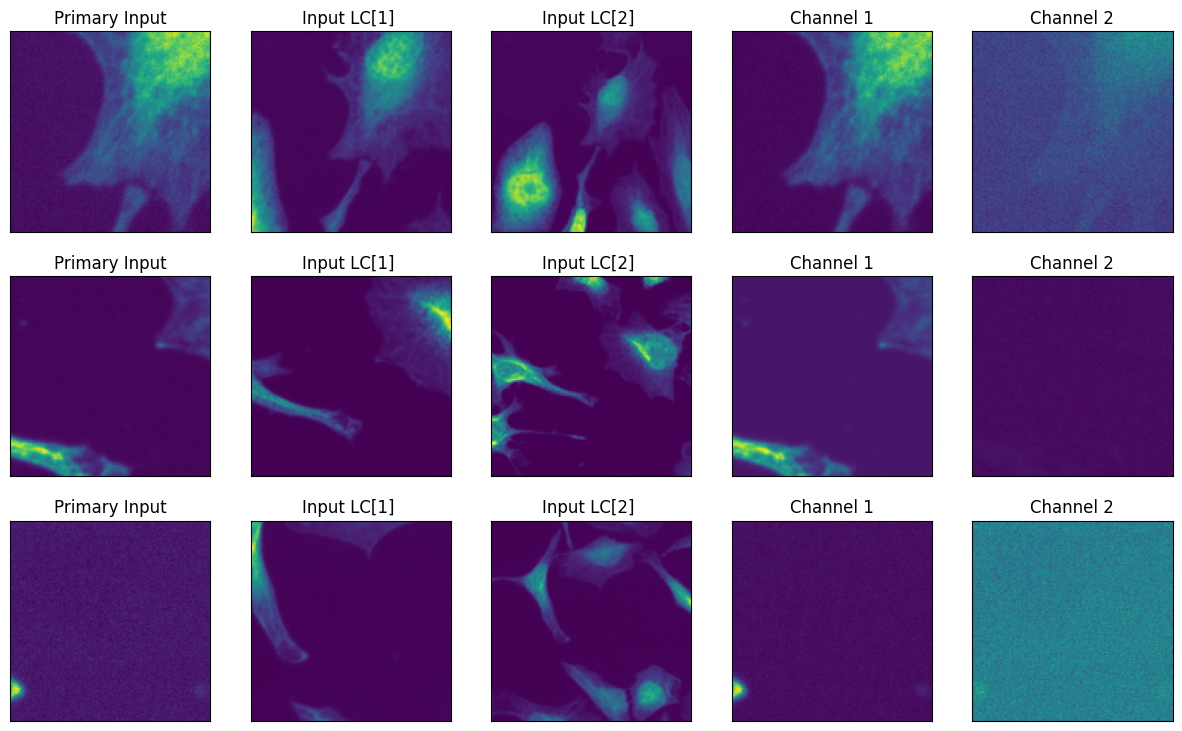

In [9]:
plot_input_patches(dataset=train_dset, num_channels=len(STRUCTURES), num_samples=3, patch_size=128)

<div class="alert alert-warning"><h4><b>Question 1.1.</b></h4>

Below are 2 examples of superimposed labeled structures with the correspondent ground truths. 
1. Which one you think it's harder to unmix? Why?
2. What are, in your opinion, features of the input data that would make unmixing more difficult? 

*Answers*
1. (b), because it shows more morphologically similar structures. MicroSplit is a content-aware method, i.e., it extracts semantic information regarding morphology, shape, brightness, etc., from the input data. Since structurally similar signal share many semantic features, the unmixing task becomes more challenging.
2. Semantic similarity between labeled structures, difference in brightness/intensity between labeled structures, colocalization, ...
</div>

<div class="alert alert-success"><h2><b>Checkpoint 1: Data Preparation</b></h2>
</div>

<hr style="height:2px;">

## 1.2. Setup <nobr>Micro$\mathbb{S}$plit</nobr> for training
Next, we create all the configs for the upcoming network training run. These lines are not very intuitive and if you don't intend to dive really deep into CAREamics and the internals of <nobr>Micro$\mathbb{S}$plit</nobr>, you might just execute these cells and move on.

In [10]:
BATCH_SIZE = 32
"""The batch size for training."""
EPOCHS = 10
"""The number of epochs to train the network."""
NM_PATH = f"/group/jug/federico/data/MBL_course/noise_models/{EXPOSURE_TIME}ms"
"""The path to the noise models to load, if any."""

'The path to the noise models to load, if any.'

In [11]:
# setting up MicroSplit parametrization
experiment_params = get_microsplit_parameters(
    algorithm="denoisplit",
    img_size=(64, 64),
    batch_size=BATCH_SIZE,
    num_epochs=EPOCHS,
    multiscale_count=3,
    noise_model_path=NM_PATH,
    target_channels=len(STRUCTURES),
)
# add data statistics that will be used for data standardization
experiment_params["data_stats"] = data_stats

In [12]:
# setting up training losses and model config (using default parameters)
loss_config = get_loss_config(**experiment_params)
model_config = get_model_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(
    **experiment_params
)
training_config = get_training_config(**experiment_params)

# setting up learning rate scheduler and optimizer (using default parameters)
lr_scheduler_config = get_lr_scheduler_config(**experiment_params)
optimizer_config = get_optimizer_config(**experiment_params)

# finally, assemble the full set of experiment configurations...
experiment_config = create_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
    lr_scheduler_config=lr_scheduler_config,
    optimizer_config=optimizer_config,
)

/localscratch/miniforge3/envs/microsplit/lib/python3.10/site-packages/careamics/utils/serializers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(lst)


In [13]:
model = VAEModule(algorithm_config=experiment_config)

[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[MultiChannelNoiseModel] Nmodels count:2
[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5.0


# **Step 1.3:** Train the prepared model!
***Note:*** if this takes too long, there were to places above where we gave you options to *(i)* reduce the amount of training data, and *(ii)* chose to train for fewer epochs. Revisit your choices if you want to!

***Note:*** Depending on the amount of GPU memory you have available, you might want to adjust the batch size. The default is 32, but you can reduce it to 16 if you run out of memory by changing the <i> batch_size </i> parameter in <i> get_microsplit_parameters </i> above.


In [14]:
# create the Trainer
trainer = Trainer(
    max_epochs=training_config.num_epochs,
    accelerator="gpu",
    enable_progress_bar=True,
    callbacks=get_callbacks("./checkpoints/"),
    precision=training_config.precision,
    gradient_clip_val=training_config.gradient_clip_val,
    gradient_clip_algorithm=training_config.gradient_clip_algorithm,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/localscratch/miniforge3/envs/microsplit/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [15]:
# start the training
trainer.fit(
    model=model,
    train_dataloaders=train_dloader,
    val_dataloaders=val_dloader,
)

You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                   | Params | Mode 
--------------------------------------------------------------------------
0 | model                  | LadderVAE              | 3.6 M  | train
1 | noise_model            | MultiChannelNoiseModel | 144    | train
2 | noise_model_likelihood | NoiseModelLikelihood   | 144    | train
3 | gaussian_likelihood    | GaussianLikelihood     | 0      | train
--------------------------------------------------------------------------
3.6 M     Trainable params
144       Non-trainable params
3.6 M     Total params
14.271    Total estimated 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

## 1.4 Visualize predictions on validation data

In order to check that the training process has been successful, we check MicroSplit predictions on the validation set.

<div class="alert alert-warning"><h4><b>Question 1.4.</b></h4>

A proper evaluation including prediction on mutliple images and computation of performance metrics will be performed later on the test data.
Do you remember what are the limitations of evaluating a model's perfomance on the validation set, instead?

</div>

Before proceeding with the evaluation, let's focus once more on how <nobr>Micro$\mathbb{S}$plit</nobr> works.

As we mentioned, <nobr>Micro$\mathbb{S}$plit</nobr> uses a modified version Hierarchical Variational Autoencoder (HVAE) similarly to COSDD and other models you encountered during the course. This architecture, given an input patch, enables the generation of multiple outputs. Technically, this happens by sampling multiple different *latent vectors* in the latent space. In mathematical terms we say that "*<nobr>Micro$\mathbb{S}$plit</nobr> is learning a full posterior of possible solutions*".

This is a cool feature that makes our variational models pretty powerful and handy!!! Indeed, averaging multiple samples (predictions) generally allows to get smoother, more consistent predictions (in other terms, it somehow averages out potential "hallucinations" of the network). Moreover, by computing the pixel-wise standard deviation over multiple samples (predictions) we can obtain a preliminary estimate of the (data) uncertainty in the model's predictions.

In this framework, the parameter `mmse_count` (int) determines the number of samples (predictions) generated for any given input patch. A larger value allows to get smoother predictions, also limiting recurring issues such as *tiling artefacts*. However, it obviously increases the time and cost of the computation. Generally, a value of >5 is enough to get decently smooth predicted frames. For reference, in our papers we often use values of 50 to get the best results. 

In [ ]:
from microsplit_reproducibility.notebook_utils.custom_dataset_2D import (
    get_unnormalized_predictions,
    get_target,
    get_input,
)

stitched_predictions, _, _ = get_unnormalized_predictions(
    model, val_dset, mmse_count=experiment_params['mmse_count'], num_workers=0, batch_size=8
)
tar = get_target(val_dset)

# get input as sum of the two channels
inp = get_input(val_dset).sum(-1)

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(20, 20))
ax[0, 0].imshow(tar[0, ..., 0], cmap="gray")
ax[0, 0].set_title("Input ch1")
ax[0, 1].imshow(tar[0, ..., 1], cmap="gray")
ax[0, 1].set_title("Input ch2")
ax[1, 0].imshow(stitched_predictions[0, ..., 0], cmap="gray")
ax[1, 0].set_title("Prediction ch1")
ax[1, 1].imshow(stitched_predictions[0, ..., 1], cmap="gray")
ax[1, 1].set_title("Prediction ch2")

In [ ]:
from microsplit_reproducibility.notebook_utils.custom_dataset_2D import full_frame_evaluation

frame_idx = 0
assert frame_idx < len(stitched_predictions), f"Frame index {frame_idx} out of bounds"
full_frame_evaluation(stitched_predictions[frame_idx], tar[frame_idx], inp[frame_idx])

<div class="alert alert-warning"><h4><b>Bonus Question</b></h4>

In this and other exercises you might have heard of "tiling/stitching artefacts". These are generally due to a mismatch in the predictions of adjacent tiles/patches. In the context of CNN and, specifically, VAE-based models, can you think about reasons why we have such effect?

*Answers*
Receptive field of CNN, Intensity mismatch due to different sampling, ...

</div>